In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

#utili
plt.rcParams['font.size'] = 18 

In [2]:
df = pd.read_csv("Google-Playstore.csv")

In [3]:
#DATA CLEANING 1
#operazione di conversione delle categorie di giochi tutti in una categoria Game
#ritengo opportuno farlo per eseguire le analisi dei dati 
dataframe=df.copy()
dataframe.loc[dataframe["Category"] == "Adventure", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Arcade", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Racing", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Role Playing", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Puzzle", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Board", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Casual", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Casino", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Action", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Card", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Strategy", "Category"] = "Game"
dataframe.loc[dataframe["Category"] == "Trivia", "Category"] = "Game"

dataframe['Category'] = dataframe['Category'].str.replace('Music & Audio', 'Music')
dataframe['Category'] = dataframe['Category'].str.replace('Educational', 'Education')

In [4]:
#DATA CLEANING2
#elimino le colonne che non mi servono
to_drop = [
    'App Id','Developer Id', 'Developer Website', 'Developer Email', 'Privacy Policy', 'Scraped Time'
]

dataframe.drop(to_drop, axis='columns', inplace=True)


#gestione delle righe che hanno valori nulli 
dataframe.dropna(subset = ['App Name','Size','Currency','Installs','Minimum Installs'], inplace = True)
cols = dataframe.columns[dataframe.isnull().any()].to_list()
print("Columns having null values are :",cols)

#rendo il numero di installazioni tipo intero, quindi numerico                                #INSTALLS
#necessario per fare l'analisi
dataframe['Installs'] = dataframe['Installs'].str.split('+').str[0]    
dataframe['Installs'].replace(',','', regex=True, inplace=True)    
dataframe['Installs'] = dataframe['Installs'].astype(np.int64) 


#converto il tempo di rilascio in formato datetime, utile per fare analisi più tardi          #RELEASED
dataframe['Released'] = pd.to_datetime(dataframe['Released'], format='%b %d, %Y',
                                 infer_datetime_format=True, errors='coerce')
#mi interessa solo l'anno di rilascio
dataframe['Released']=dataframe['Released'].dt.year 
dataframe['Released'] = dataframe['Released'].fillna(0).astype(np.int64)

#converto size da tipo object in tipo float                                                   #SIZE
#sistemo le unità di misura delle grandezze
dataframe['Size'] = dataframe['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
dataframe['Size'] = dataframe['Size'].apply(lambda x: str(x).replace(',', '.') if ',' in str(x) else x)
dataframe['Size'] = dataframe['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
dataframe['Size'] = dataframe['Size'].apply(lambda x: str(x).replace('Varies with device', '0') if 'Varies with device' in str(x) else x)
dataframe['Size'] = dataframe['Size'].apply(lambda x: float(str(x).replace('G', '')) * 1000 if 'G' in str(x) else x)
dataframe['Size'] = dataframe['Size'].apply(lambda x: float(x))


#introduco una colonna type che avrà valore free o paid, utile per l'analisi 
#ed elimino la colonna free booleana
dataframe['Type'] = np.where(dataframe['Free'] == True,'Free','Paid')
dataframe.drop(['Free'],axis=1, inplace= True )

#convergo il content rating in 3 grandi tipi: everyone, teen, adults
#in quanto si osserva che ci sono corrispondenze, es.mature 17+ e adults only 18+ ritengo sia adults.
dataframe["Content Rating"]=dataframe["Content Rating"].replace("Unrated","Everyone")
dataframe["Content Rating"]=dataframe["Content Rating"].replace("Everyone 10+","Teen")
dataframe["Content Rating"]=dataframe["Content Rating"].replace("Mature 17+","Adults")
dataframe["Content Rating"]=dataframe["Content Rating"].replace("Adults only 18+","Adults")

Columns having null values are : ['Rating', 'Rating Count', 'Minimum Android', 'Released']


In [5]:
#DATA CLEANING 3

dataframe['Rating Type'] = 'Senza recensioni'
dataframe.loc[(dataframe['Rating Count'] > 0) & (dataframe['Rating Count'] <= 10000.0),'Rating Type'] = 'Meno di 10K'
dataframe.loc[(dataframe['Rating Count'] > 10000) & (dataframe['Rating Count'] <= 100000.0),'Rating Type'] = 'Tra 10K e 100K'
dataframe.loc[(dataframe['Rating Count'] > 100000) & (dataframe['Rating Count'] <= 500000.0),'Rating Type'] = 'Tra 100K e 500K'
dataframe.loc[(dataframe['Rating Count'] > 500000) & (dataframe['Rating Count'] <= 138557570.0),'Rating Type'] = 'Più di 500K'



#converto tutte le valute in dollari
#NON HO BISOGNO DI CONVERTIRE i costi perché è stato provato che se una app è a pagamento allora ha la valuta in dollari
#quindi posso tranquillamente cambiare la valuta, in quanto tutte le app con valuta diverso dal dollaro ha costo = 0.0
dataframe["Currency"]=dataframe["Currency"].replace("XXX","USD")
dataframe["Currency"]=dataframe["Currency"].replace("CAD","USD")
dataframe["Currency"]=dataframe["Currency"].replace("EUR","USD")
dataframe["Currency"]=dataframe["Currency"].replace("INR","USD")
dataframe["Currency"]=dataframe["Currency"].replace("VND","USD")
dataframe["Currency"]=dataframe["Currency"].replace("GBP","USD")
dataframe["Currency"]=dataframe["Currency"].replace("BRL","USD")
dataframe["Currency"]=dataframe["Currency"].replace("KRW","USD")
dataframe["Currency"]=dataframe["Currency"].replace("TRY","USD")
dataframe["Currency"]=dataframe["Currency"].replace("RUB","USD")
dataframe["Currency"]=dataframe["Currency"].replace("SGD","USD")
dataframe["Currency"]=dataframe["Currency"].replace("AUD","USD")
dataframe["Currency"]=dataframe["Currency"].replace("PKR","USD")
dataframe["Currency"]=dataframe["Currency"].replace("ZAR","USD")

In [6]:
dataframe['Rating Type'].value_counts()

Meno di 10K         1192840
Senza recensioni    1082328
Tra 10K e 100K        30241
Tra 100K e 500K        5538
Più di 500K            1665
Name: Rating Type, dtype: int64

In [7]:
dataframe['Installs'].unique()

array([         10,        5000,          50,         100,        1000,
               500,       50000,       10000,           1,      500000,
            100000,           5,    10000000,     1000000,     5000000,
                 0,   100000000,    50000000,  1000000000,   500000000,
        5000000000, 10000000000], dtype=int64)

In [8]:
#LE COLONNE CHE HANNO VALORE NULLO SONO
#RATING/RATING COUNT--->riempio con 0
#MINIMUM ANDROID--->non si fa analisi
#RELEASED--->riempio con 0
dataframe.isnull().sum()


App Name                0
Category                0
Rating              22573
Rating Count        22573
Installs                0
Minimum Installs        0
Maximum Installs        0
Price                   0
Currency                0
Size                    0
Minimum Android      6530
Released                0
Last Updated            0
Content Rating          0
Ad Supported            0
In App Purchases        0
Editors Choice          0
Type                    0
Rating Type             0
dtype: int64

In [9]:
dataframe['Category'].value_counts()

Game                       270973
Education                  262376
Music                      159099
Tools                      143972
Business                   143758
Entertainment              138266
Lifestyle                  118322
Books & Reference          116726
Personalization             89209
Health & Fitness            83499
Productivity                79685
Shopping                    75247
Food & Drink                73919
Travel & Local              67280
Finance                     65454
Communication               48158
Sports                      47473
Social                      44725
News & Magazines            42801
Photography                 35552
Medical                     32063
Maps & Navigation           26722
Simulation                  23268
Art & Design                18536
Auto & Vehicles             18276
House & Home                14368
Video Players & Editors     14014
Events                      12839
Beauty                      11771
Word          

In [10]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312612 entries, 0 to 2312943
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   App Name          object 
 1   Category          object 
 2   Rating            float64
 3   Rating Count      float64
 4   Installs          int64  
 5   Minimum Installs  float64
 6   Maximum Installs  int64  
 7   Price             float64
 8   Currency          object 
 9   Size              float64
 10  Minimum Android   object 
 11  Released          int64  
 12  Last Updated      object 
 13  Content Rating    object 
 14  Ad Supported      bool   
 15  In App Purchases  bool   
 16  Editors Choice    bool   
 17  Type              object 
 18  Rating Type       object 
dtypes: bool(3), float64(5), int64(3), object(8)
memory usage: 306.6+ MB


In [11]:
dataframe.head(8)

,App Name,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Price,Currency,Size,Minimum Android,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Type,Rating Type
0,Gakondo,Game,0.0,0.0,10,10.0,15,0.0,USD,10.0,7.1 and up,2020,"Feb 26, 2020",Everyone,False,False,False,Free,Senza recensioni
1,Ampere Battery Info,Tools,4.4,64.0,5000,5000.0,7662,0.0,USD,2.9,5.0 and up,2020,"May 06, 2021",Everyone,True,False,False,Free,Meno di 10K
2,Vibook,Productivity,0.0,0.0,50,50.0,58,0.0,USD,3.7,4.0.3 and up,2019,"Aug 19, 2019",Everyone,False,False,False,Free,Senza recensioni
3,Smart City Trichy Public Service Vehicles 17UC...,Communication,5.0,5.0,10,10.0,19,0.0,USD,1.8,4.0.3 and up,2018,"Oct 13, 2018",Everyone,True,False,False,Free,Meno di 10K
4,GROW.me,Tools,0.0,0.0,100,100.0,478,0.0,USD,6.2,4.1 and up,2020,"Nov 12, 2018",Everyone,False,False,False,Free,Senza recensioni
5,IMOCCI,Social,0.0,0.0,50,50.0,89,0.0,USD,46.0,6.0 and up,2018,"Dec 20, 2019",Teen,False,True,False,Free,Senza recensioni
6,unlimited 4G data prank free app,Libraries & Demo,4.5,12.0,1000,1000.0,2567,0.0,USD,2.5,4.1 and up,2019,"Sep 27, 2019",Everyone,True,False,False,Free,Meno di 10K
7,The Everyday Calendar,Lifestyle,2.0,39.0,500,500.0,702,0.0,USD,16.0,5.0 and up,2019,"Jun 21, 2019",Everyone,False,False,False,Free,Meno di 10K


[]

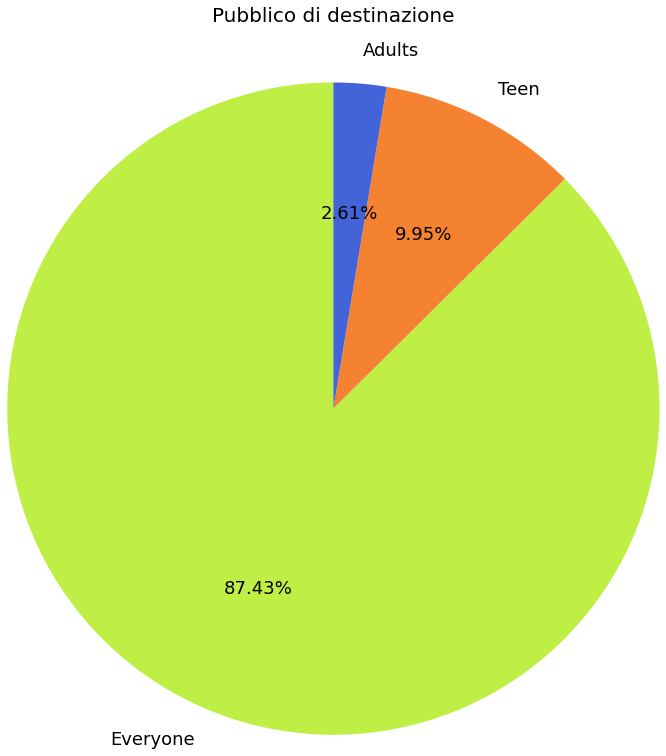

In [12]:
#GRAFO A TORTA DEL PUBBLICO DI DESTINAZIONE
plt.figure(figsize=(5,5))
plt.pie(dataframe['Content Rating'].value_counts(),autopct='%0.2f%%',
        labels=['Everyone','Teen','Adults'],colors=['#bfef45','#f58231','#4363d8'],startangle=90,radius=3,
       )
plt.title('Pubblico di destinazione',fontdict={'size':20},x=0.5, y=1.9) 
plt.plot()

<AxesSubplot:>

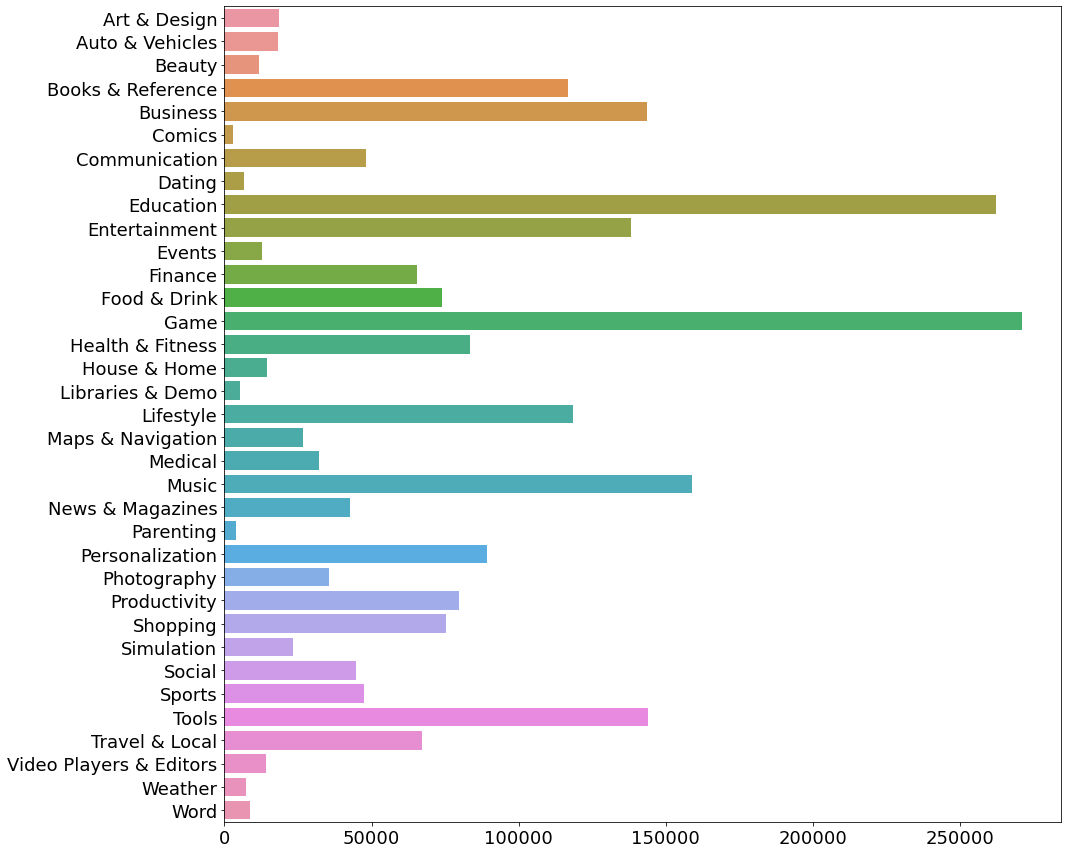

In [13]:
#CATEGORIE PRESENTI NEL DATASET
category_rating = dataframe['Category'].value_counts().sort_index()
plt.figure(figsize=(15,15))
sns.barplot(category_rating.values,category_rating.index )


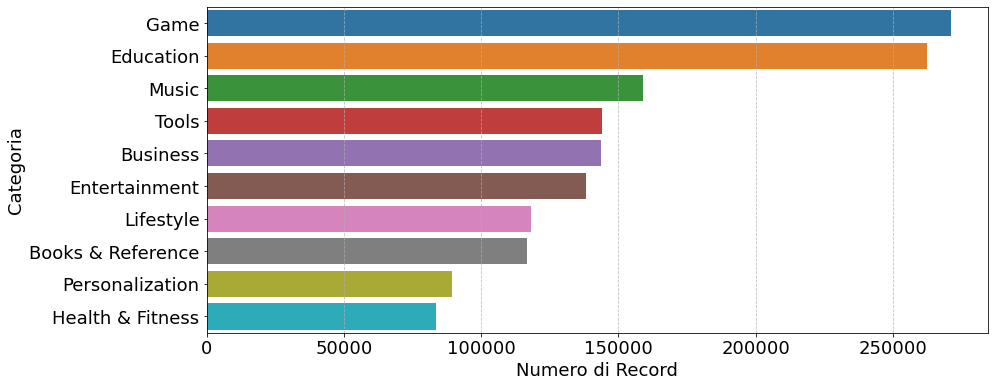

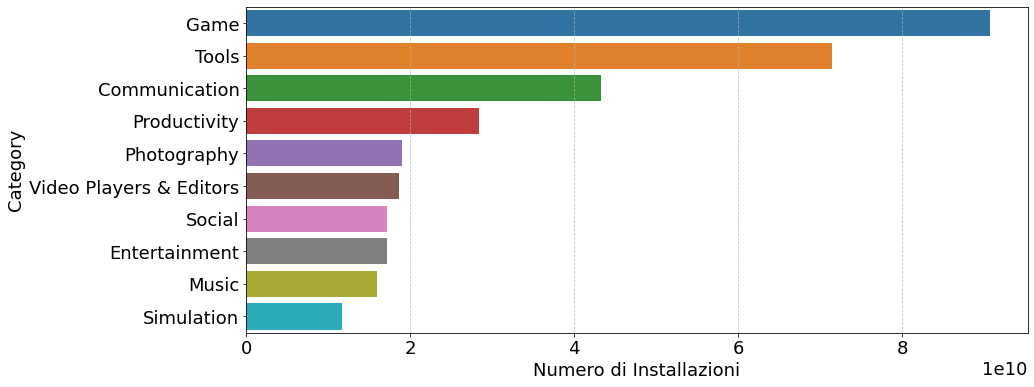

In [48]:
#CATEGORIE PRESENTI NEL DATASET
category_rating = dataframe['Category'].value_counts().head(10)
plt.figure(figsize=(14,6))
plt.grid(axis='x', linestyle='--', alpha=0.8)   
plt.xlabel('Numero di Record')
plt.ylabel('Categoria')
sns.barplot(category_rating.values,category_rating.index )


highest_ins = dataframe.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 6))
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.xlabel('Numero di Installazioni')
plt.ylabel('Categoria')  
sns.barplot(highest_ins.values, highest_ins.index)

plt.show()

Text(0.5, 1.0, 'Top 10 categorie di app')

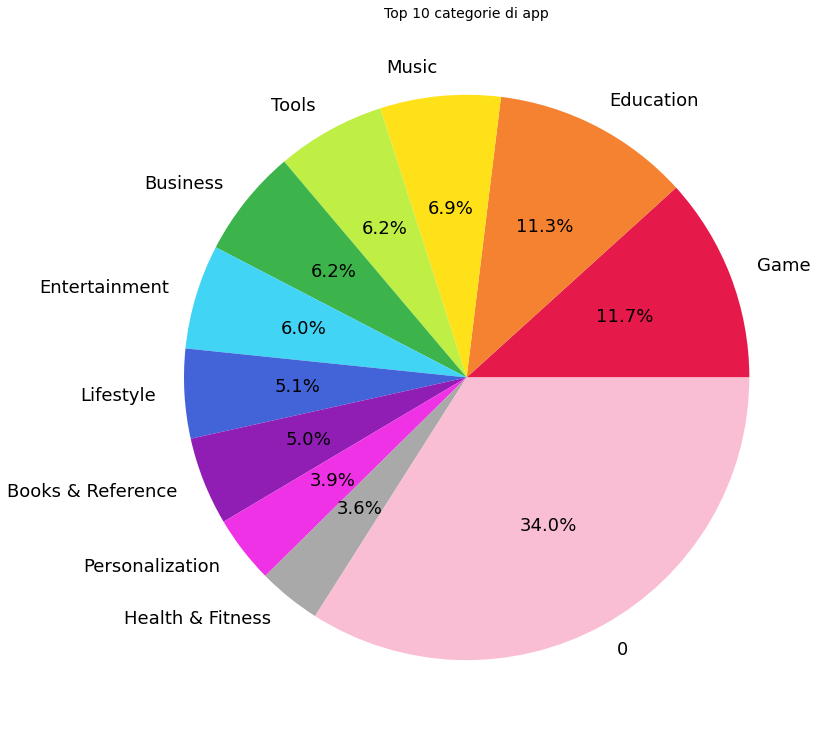

In [14]:
#GRAFO A TORTA DELLE top 10 CATEGORIE 
dataframe2=pd.crosstab(index=dataframe['Category'],columns=['numeri'],colnames=['category'])
dataframe2=dataframe2.sort_values('numeri', ascending=False)
dfTOP10 = dataframe2[:10].copy()

new_row = pd.DataFrame(data = {
    'numeri' : [dataframe2['numeri'][10:].sum()]})
dfTOP10 = pd.concat([dfTOP10, new_row])


plt.figure(figsize=(15,13))
data = dfTOP10['numeri']

labels = data.keys()
plt.pie(data, labels= labels, colors=['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8','#911eb4','#f032e6','#a9a9a9','#fabed4'],autopct='%.1f%%') 

plt.title("Top 10 categorie di app", fontsize=14)
#plt.legend(loc='upper right')

Text(0.5, 1.0, 'Top 10 categorie per installazioni')

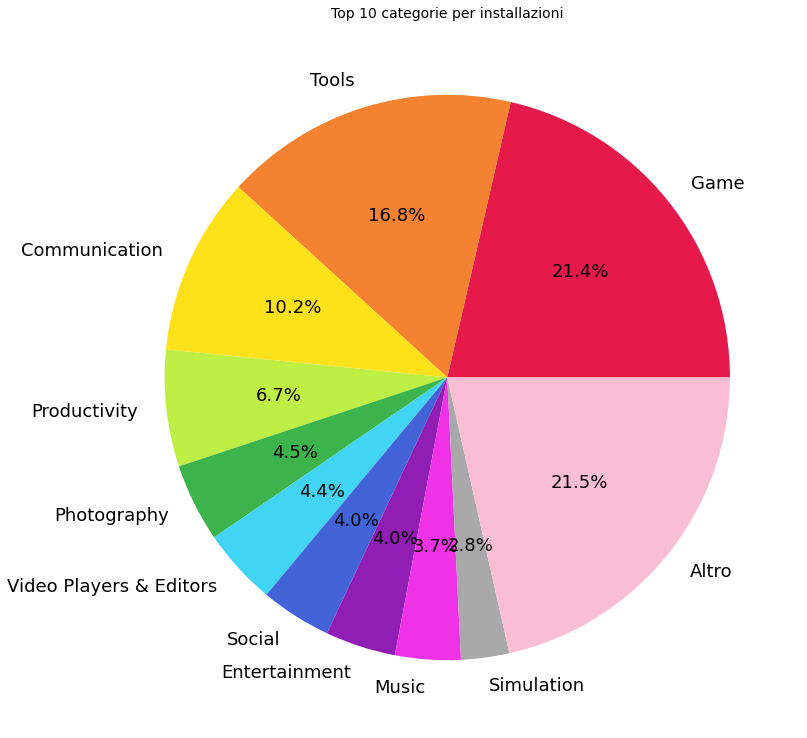

In [15]:
highest_ins = dataframe.groupby('Category')['Installs'].sum().sort_values(ascending=False).reset_index()



installTOP10 = highest_ins[:10].copy()

new_row = pd.DataFrame(data = {
    'Installs' : [highest_ins['Installs'][10:].sum()]})
installTOP10 = pd.concat([installTOP10, new_row])


plt.figure(figsize=(15,13))
data = installTOP10['Installs']

labels = data.keys()
plt.pie(data, labels= ['Game','Tools','Communication','Productivity','Photography','Video Players & Editors','Social','Entertainment','Music','Simulation','Altro'], colors=['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8','#911eb4','#f032e6','#a9a9a9','#fabed4'],autopct='%.1f%%') 

plt.title("Top 10 categorie per installazioni", fontsize=14)




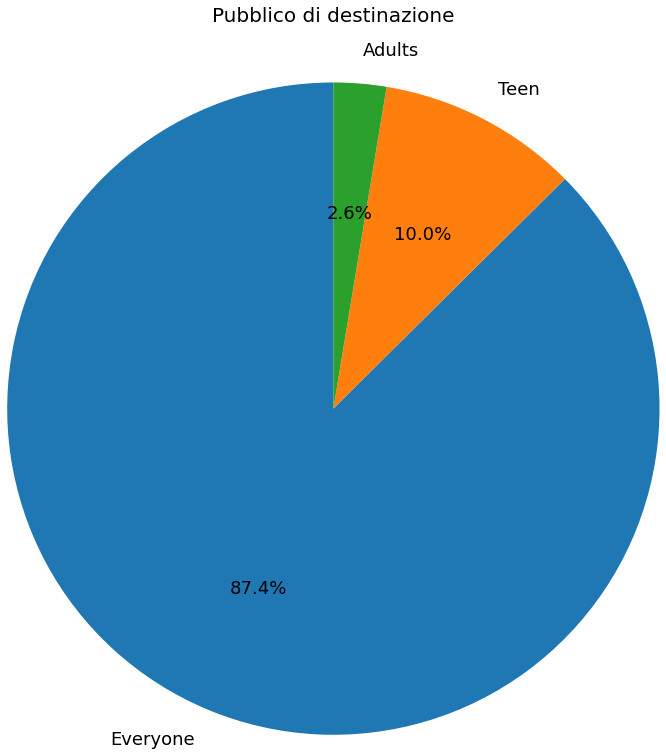

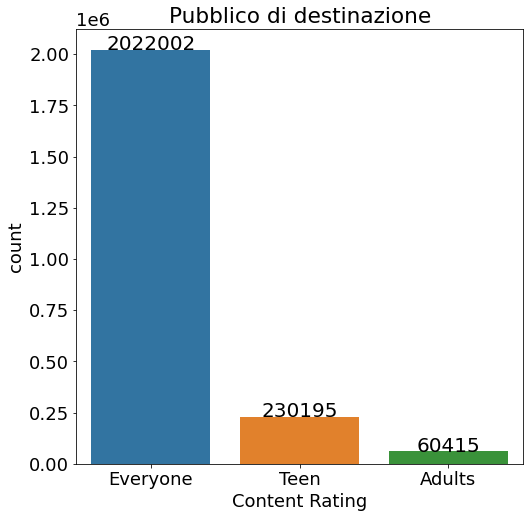

In [16]:
#GRAFO A TORTA DEL PUBBLICO DI DESTINAZIONE
plt.figure(figsize=(5,5))
plt.pie(dataframe['Content Rating'].value_counts(),autopct='%0.1f%%',
        labels=['Everyone','Teen','Adults'],startangle=90,radius=3,
       )
plt.title('Pubblico di destinazione',fontdict={'size':20},x=0.5, y=1.9) 
plt.plot()


plt.figure(figsize=(8,8))
ax = sns.countplot(dataframe['Content Rating']);
plt.title("Pubblico di destinazione")

for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
    
plt.show()



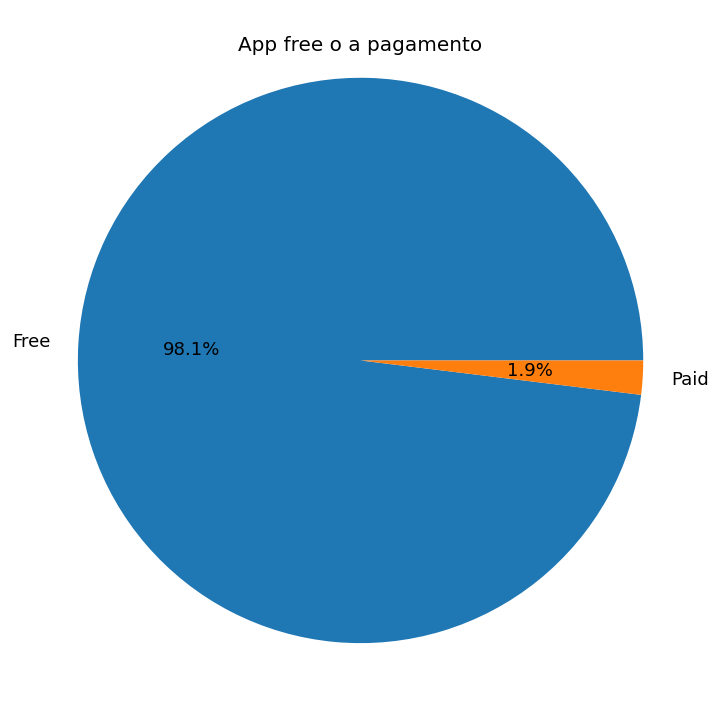

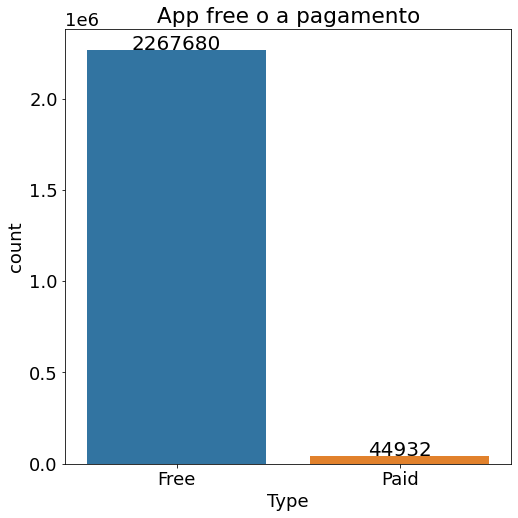

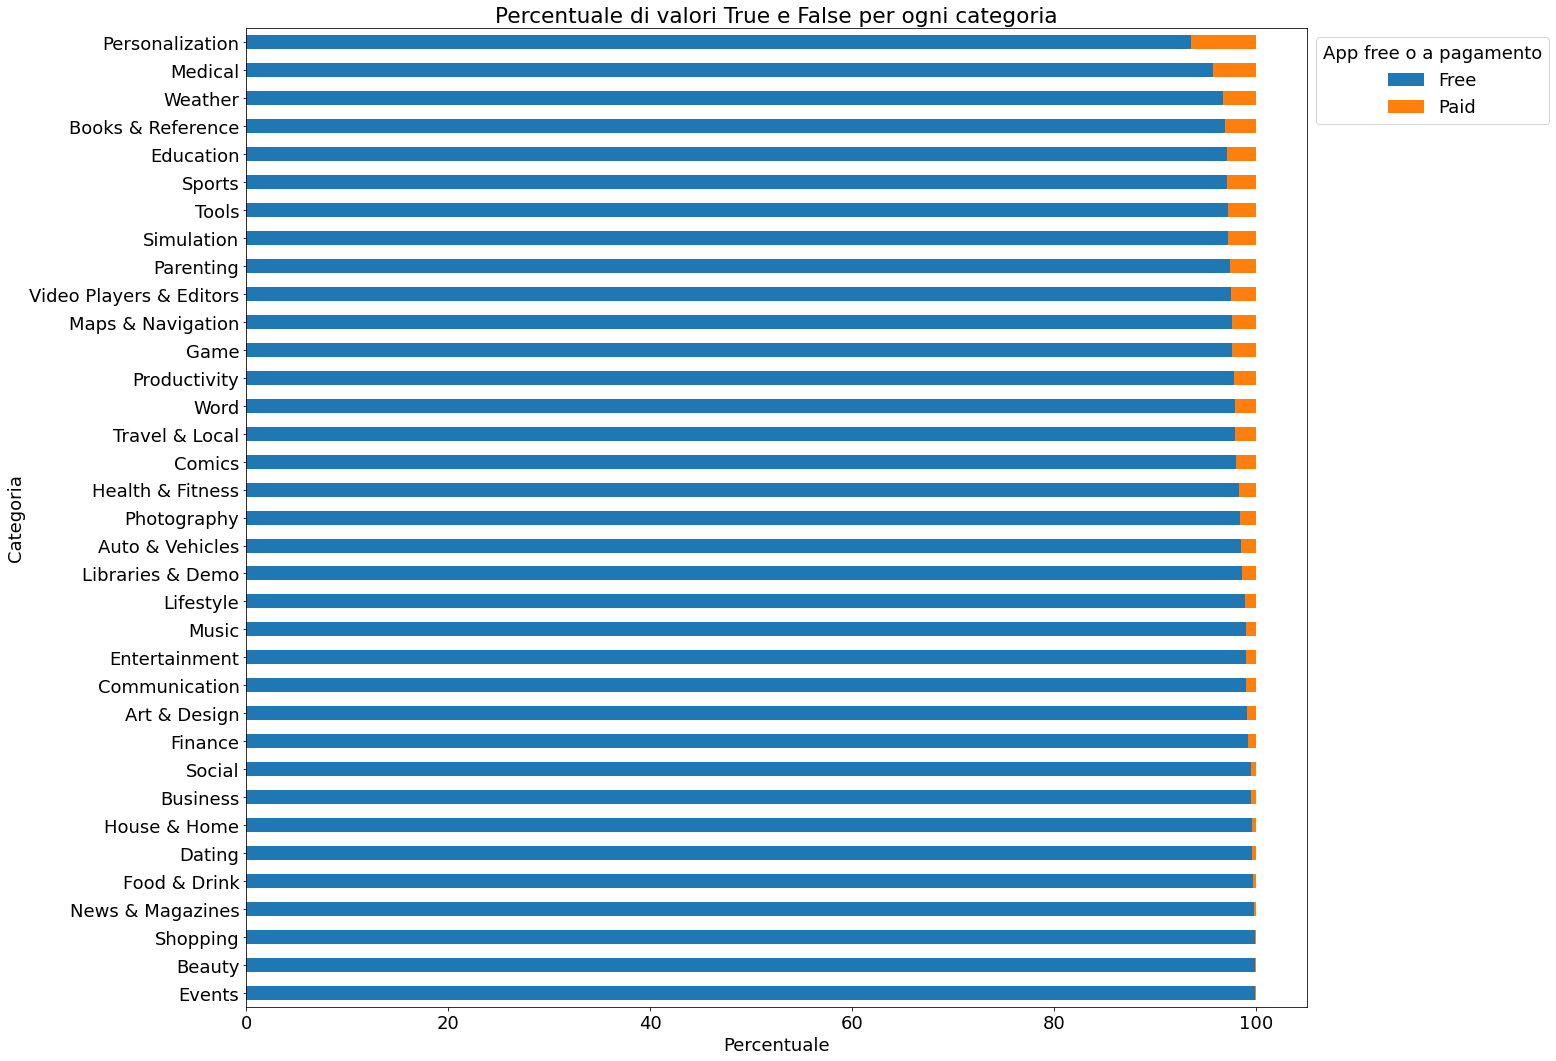

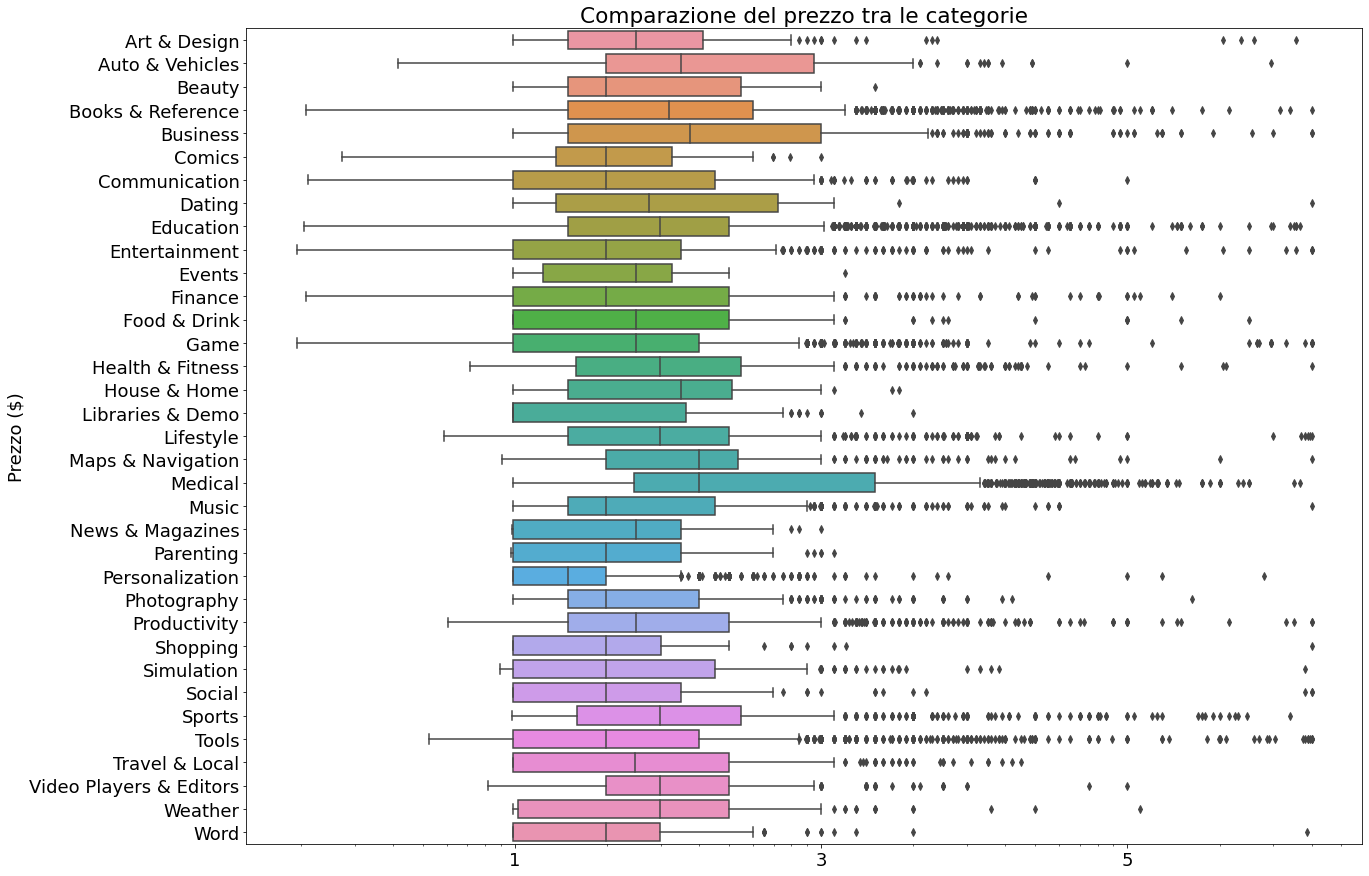

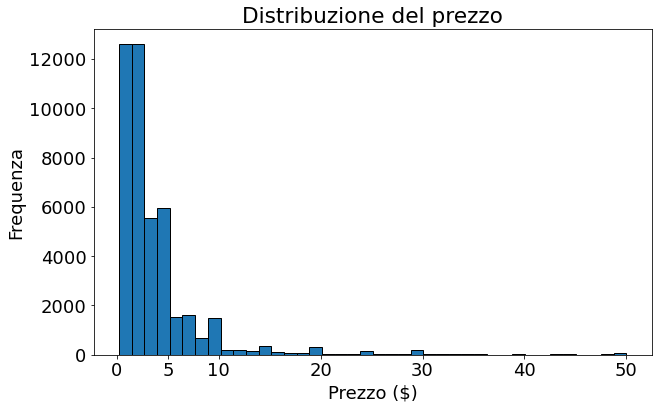

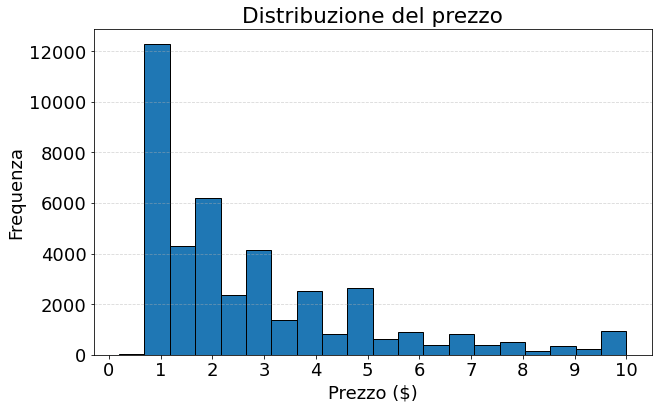

In [89]:

plt.figure(figsize=(15,13))
data = dataframe['Type'].value_counts()
labels = data.keys()
plt.pie(data, labels= labels,autopct='%.1f%%') 

plt.title("App free o a pagamento", fontsize=20, x=0.5, y=0.93)
#plt.legend(loc='upper right')


#APP A PAGAMENTO O NON
plt.figure(figsize=(8,8))
ax = sns.countplot(dataframe['Type']);
plt.title("App free o a pagamento")

for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
    

result = dataframe.groupby('Category')['Type'].value_counts(normalize=True) * 100
result = result.unstack().sort_values(by="Paid")


result.plot(kind='barh', stacked=True,figsize=(19, 18))


plt.title('Percentuale di valori True e False per ogni categoria')
plt.xlabel('Percentuale')
plt.ylabel('Categoria')
plt.legend(title='App free o a pagamento', bbox_to_anchor=(1, 1))





#COMPARAZIONE TRA IL PREZZO PER OGNI CATEGORIA
fig, ax = plt.subplots(figsize=(20, 15))

category_order = dataframe[dataframe['Price'] != 0]['Category'].unique()
category_order.sort()  # Ordinamento alfabetico delle categorie


sns.boxplot(y='Category', x='Price', data=dataframe[dataframe['Price'] != 0], order=category_order)

ax.set_xscale('log')

ax.set(title='Comparazione del prezzo tra le categorie',
       xlabel='', ylabel='Prezzo ($)')

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

x_ticks = [0.3, 0.5, 1, 3, 5, 10, 30, 100, 300]
ax.set_xticklabels(x_ticks)



filtered_df = dataframe[(dataframe['Price'] != 0) & (dataframe['Price'] <= 50)]
price_bins = [0, 5, 10, 20,30,40, 50]
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Price'], bins=40, edgecolor='black')
plt.xlabel('Prezzo ($)')
plt.ylabel('Frequenza')
plt.title('Distribuzione del prezzo')
plt.xticks(price_bins)

plt.show()


filtered_df = dataframe[(dataframe['Price'] != 0) & (dataframe['Price'] <= 10)]
price_bins = [0, 1, 2, 3,4,5, 6,7,8,9,10]
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Price'], bins=20, edgecolor='black')
plt.xlabel('Prezzo ($)')
plt.ylabel('Frequenza')
plt.title('Distribuzione del prezzo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(price_bins)

plt.show()

    

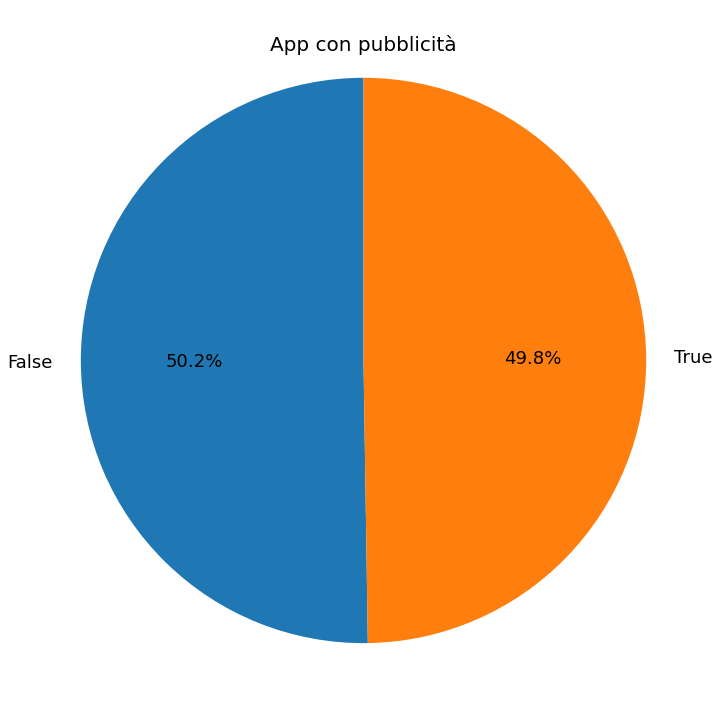

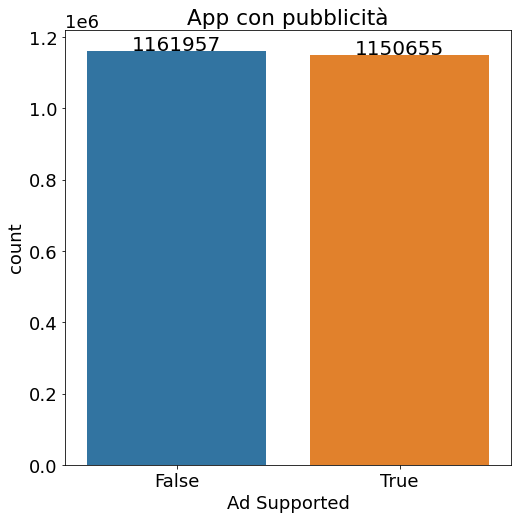

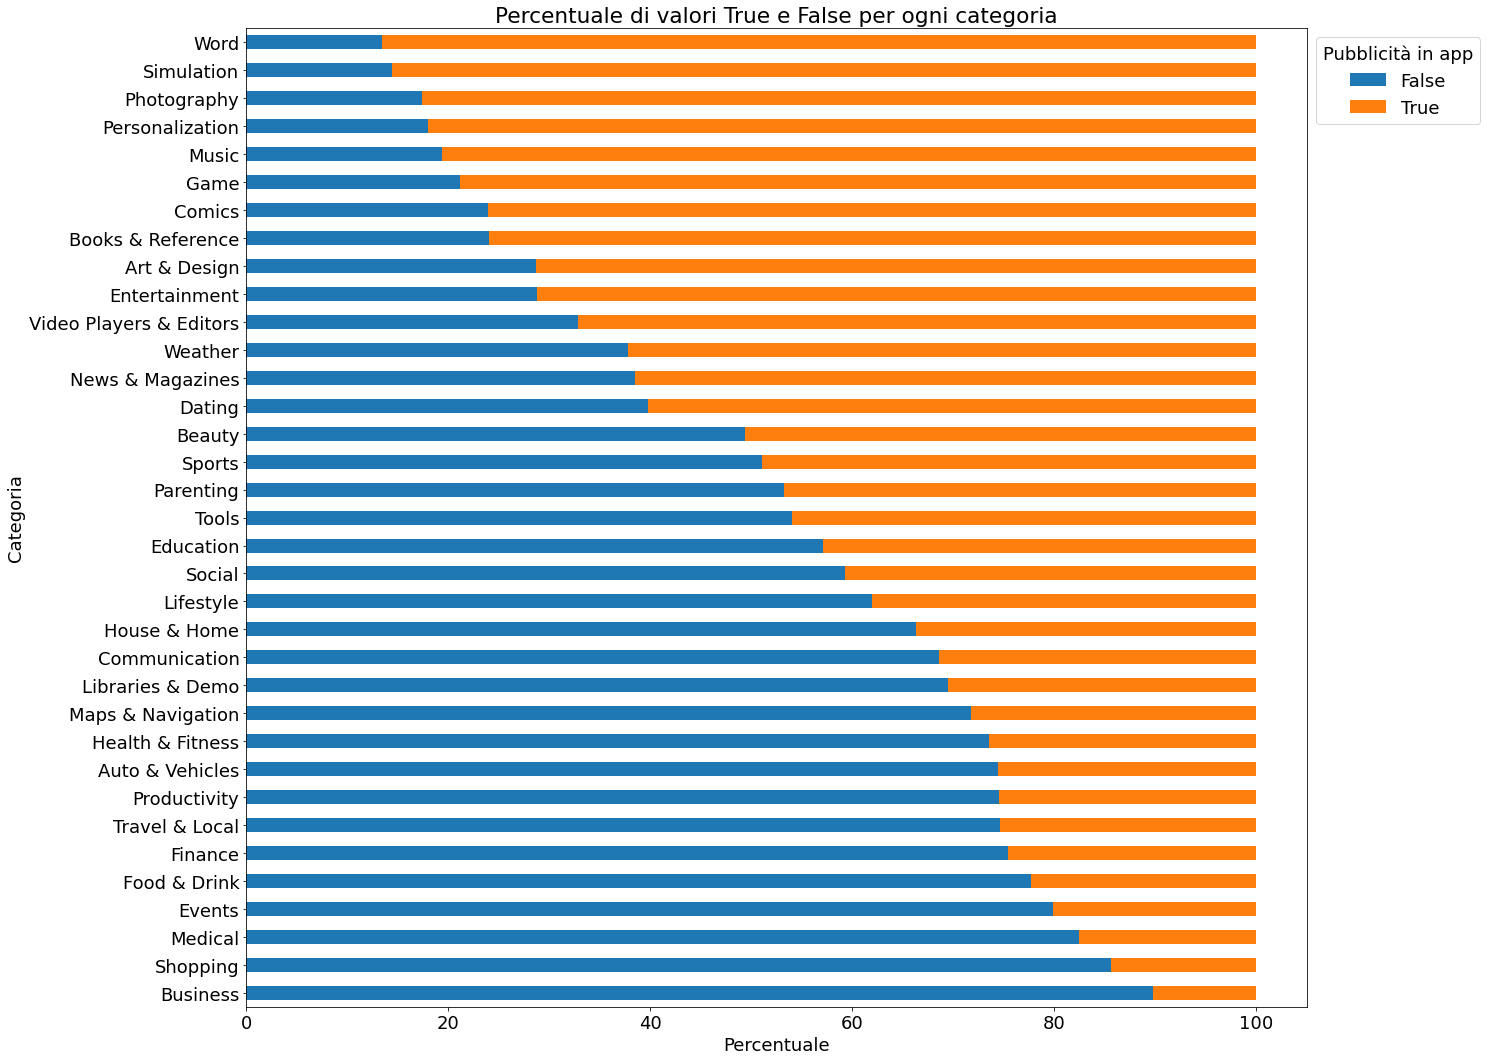

In [18]:
#APP CON PUBBLICITA O NON
plt.figure(figsize=(15,13))
data = dataframe['Ad Supported'].value_counts()
labels = data.keys()
plt.pie(data, labels= labels,autopct='%.1f%%',startangle=90) 

plt.title("App con pubblicità",  fontsize=20, x=0.5, y=0.93)
#plt.legend(loc='upper right')

#APP CON PUBBLICITA O NON
plt.figure(figsize=(8,8))
ax = sns.countplot(dataframe['Ad Supported']);
plt.title("App con pubblicità")

for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
    
    
    

result = dataframe.groupby('Category')['Ad Supported'].value_counts(normalize=True) * 100
result = result.unstack().sort_values(by=True)


result.plot(kind='barh', stacked=True,figsize=(19, 18))


plt.title('Percentuale di valori True e False per ogni categoria')
plt.xlabel('Percentuale')
plt.ylabel('Categoria')
plt.legend(title='Pubblicità in app', bbox_to_anchor=(1, 1))

plt.show()
    

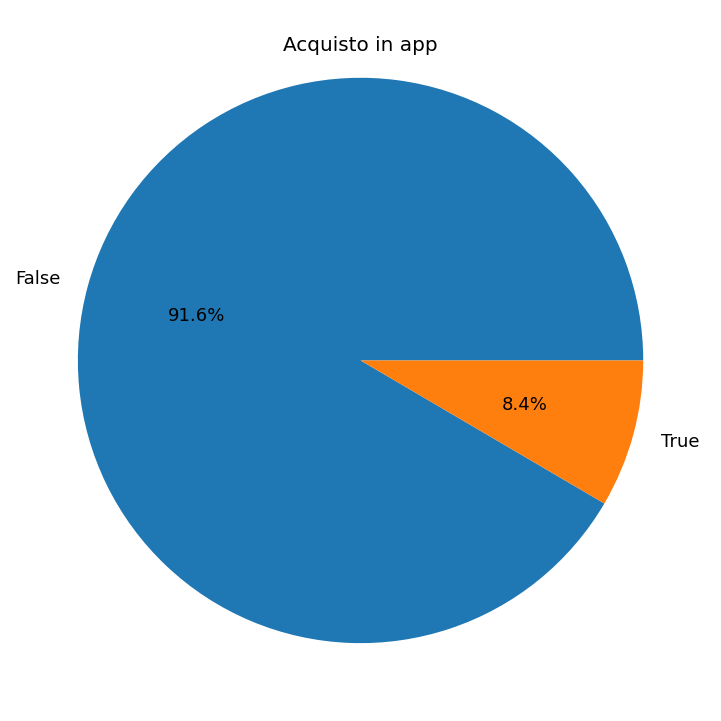

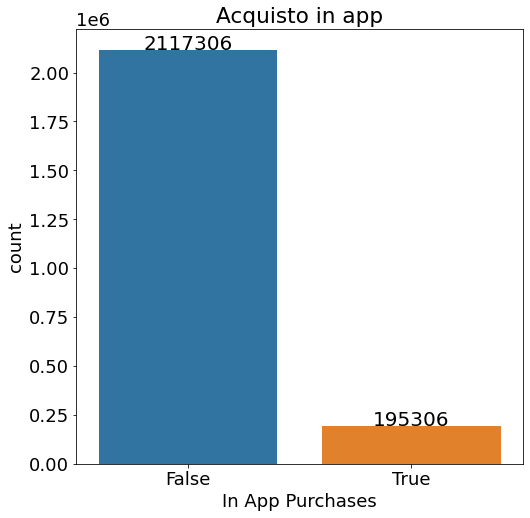

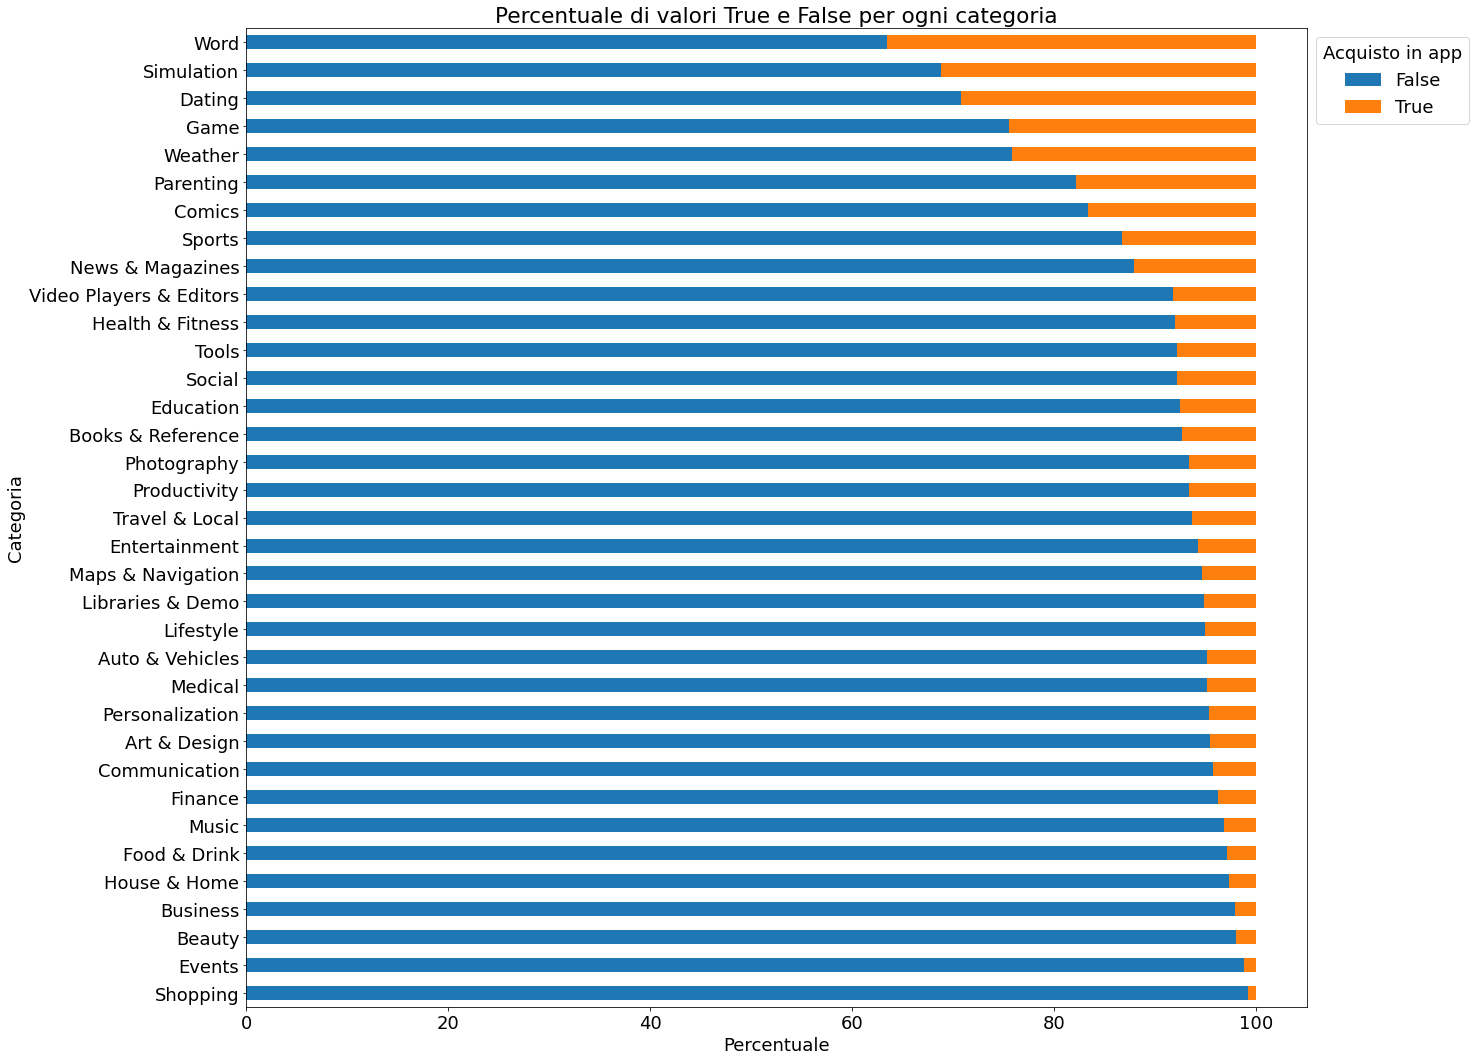

In [19]:
#APP CON ACQUISTI IN APP
plt.figure(figsize=(15,13))
data = dataframe['In App Purchases'].value_counts()
labels = data.keys()
plt.pie(data, labels= labels,autopct='%.1f%%') 

plt.title("Acquisto in app", fontsize=20, x=0.5, y=0.93)
#plt.legend(loc='upper right')


plt.figure(figsize=(8,8))
ax = sns.countplot(dataframe['In App Purchases']);
plt.title("Acquisto in app")
for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
    





result = dataframe.groupby('Category')['In App Purchases'].value_counts(normalize=True) * 100
result = result.unstack().sort_values(by=True)


result.plot(kind='barh', stacked=True,figsize=(19, 18))


plt.title('Percentuale di valori True e False per ogni categoria')
plt.xlabel('Percentuale')
plt.ylabel('Categoria')
plt.legend(title='Acquisto in app', bbox_to_anchor=(1, 1))

plt.show()

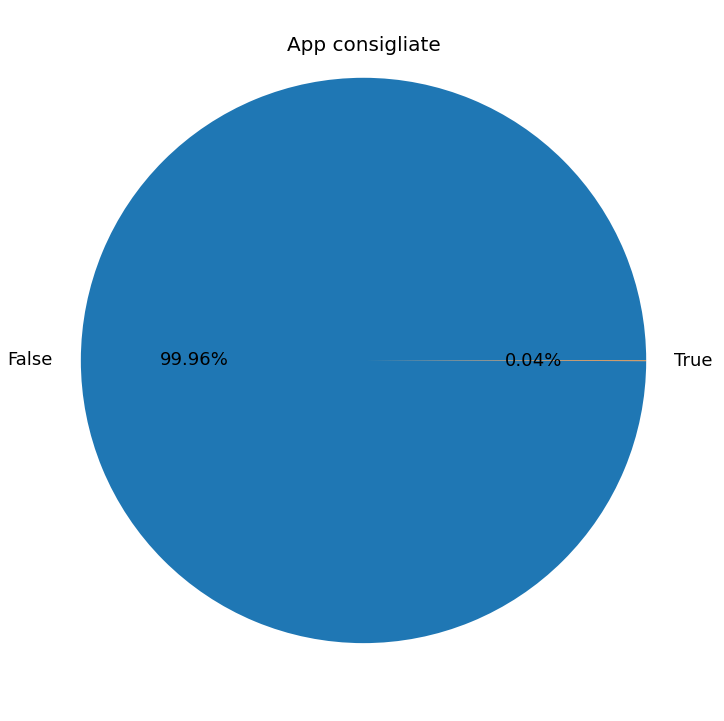

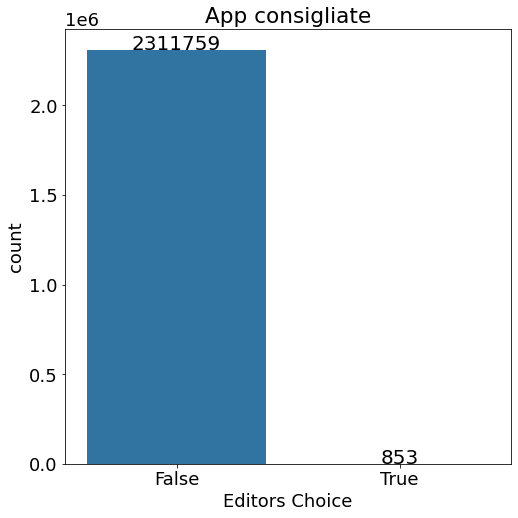

In [20]:
#APP CONSIGLIATI
plt.figure(figsize=(15,13))
data = dataframe['Editors Choice'].value_counts()
labels = data.keys()
plt.pie(data, labels= labels,autopct='%.2f%%') 

plt.title("App consigliate", fontsize=20, x=0.5, y=0.93)
#plt.legend(loc='upper right')


plt.figure(figsize=(8,8))
ax = sns.countplot(dataframe['Editors Choice']);
plt.title("App consigliate")
for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
  

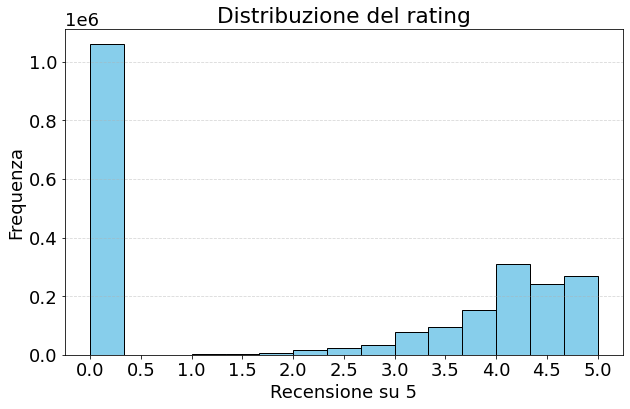

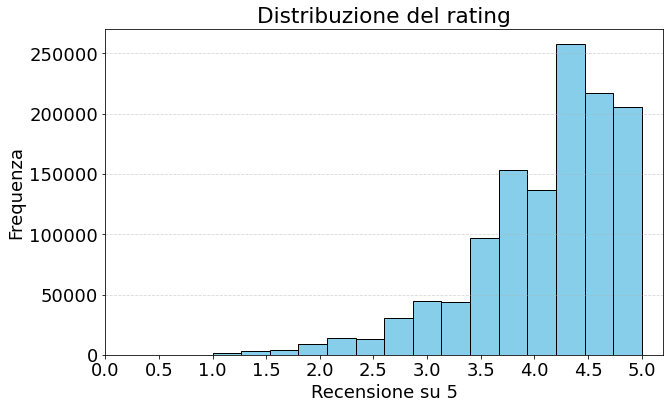

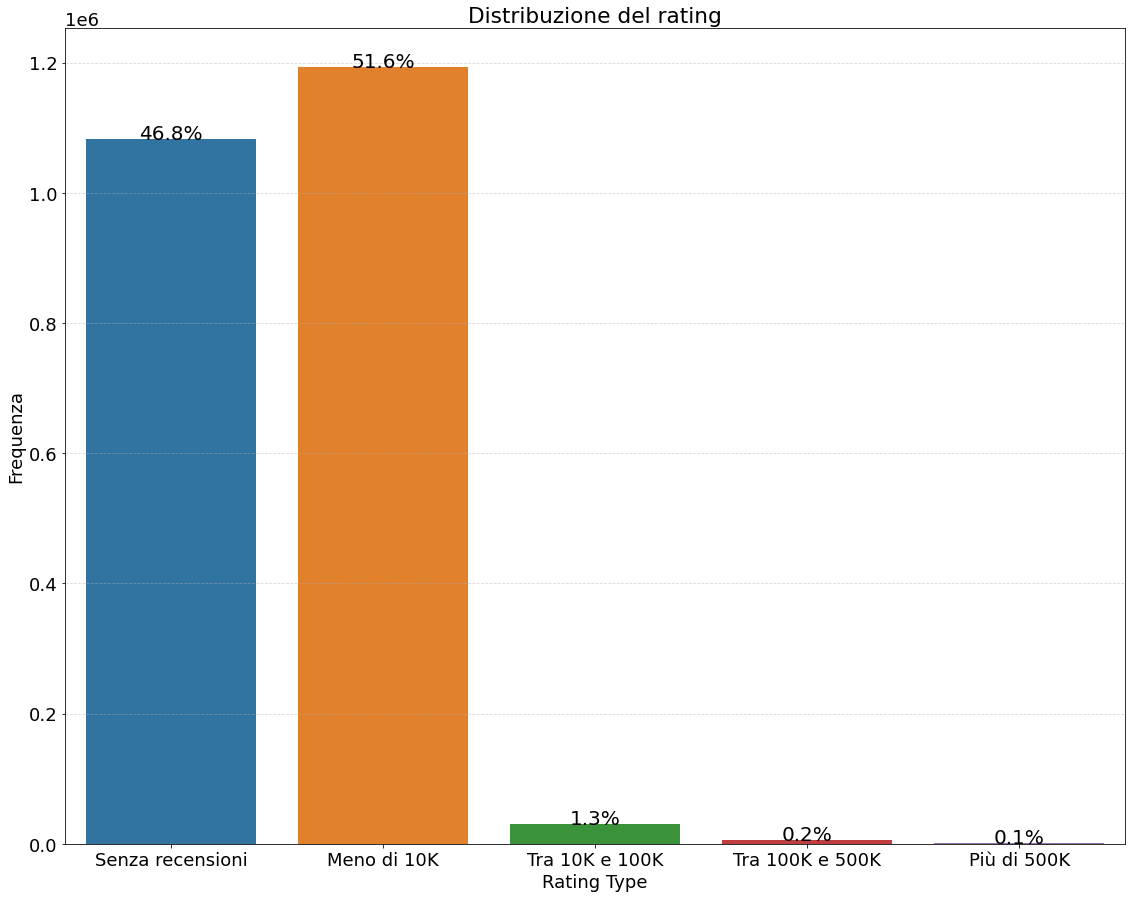

In [21]:
#RATING



#DISTRIBUZIONE RATING
plt.figure(figsize=(10, 6))

rec_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
plt.hist(dataframe['Rating'], bins=15, edgecolor='black', color='skyblue')
plt.xlabel('Recensione su 5')
plt.ylabel('Frequenza')
plt.title('Distribuzione del rating')


plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rec_bins)


#DISTRIBUZIONE RATING SENZA I RATING NULLI
over_0 = dataframe[dataframe['Rating'] > 0]['Rating']

plt.figure(figsize=(10, 6))

rec_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
plt.hist(over_0, bins=15, edgecolor='black', color='skyblue')
plt.xlabel('Recensione su 5')
plt.ylabel('Frequenza')
plt.title('Distribuzione del rating')


plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rec_bins)


plt.show()


#DISTRIBUZIONE TIPI DI RATING

    
plt.figure(figsize=(19, 15))
ax = sns.countplot(dataframe['Rating Type'])
plt.title("Distribuzione del rating")
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.5)
total = len(dataframe['Rating Type'])  

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)  
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', size=20)

plt.show()


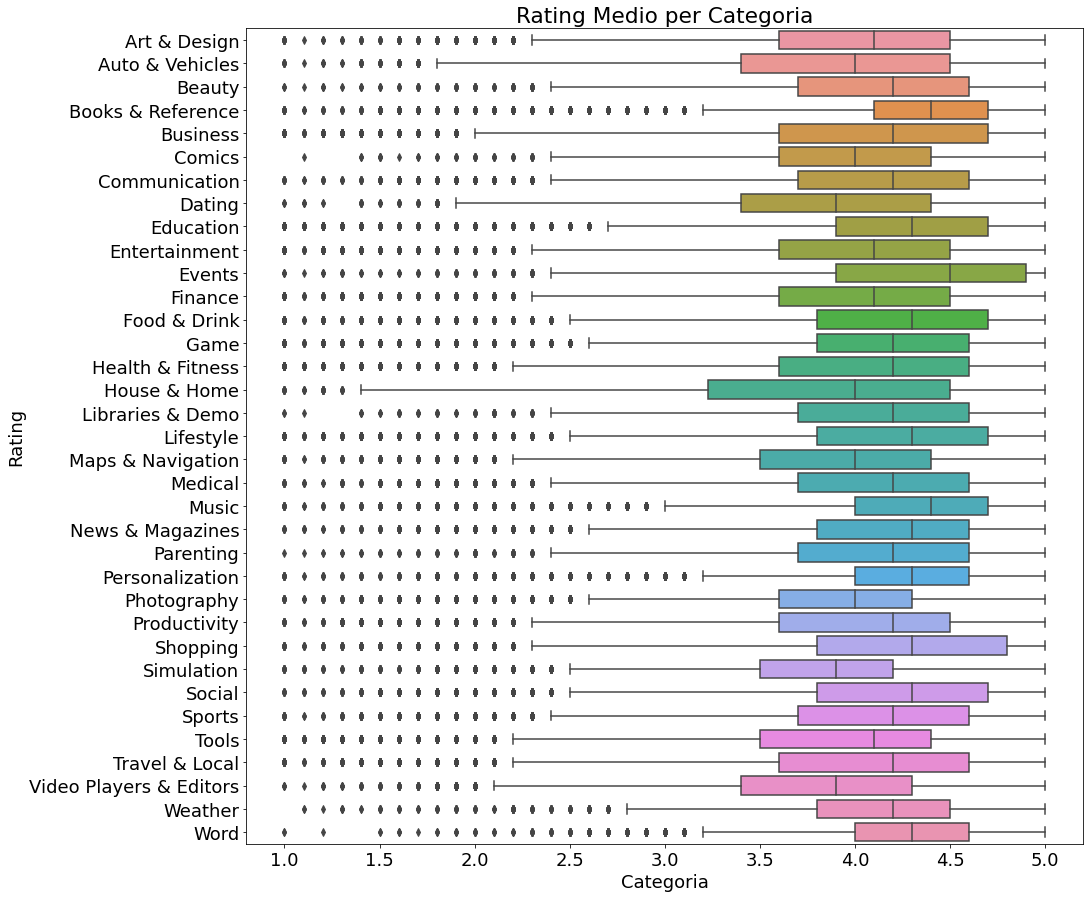

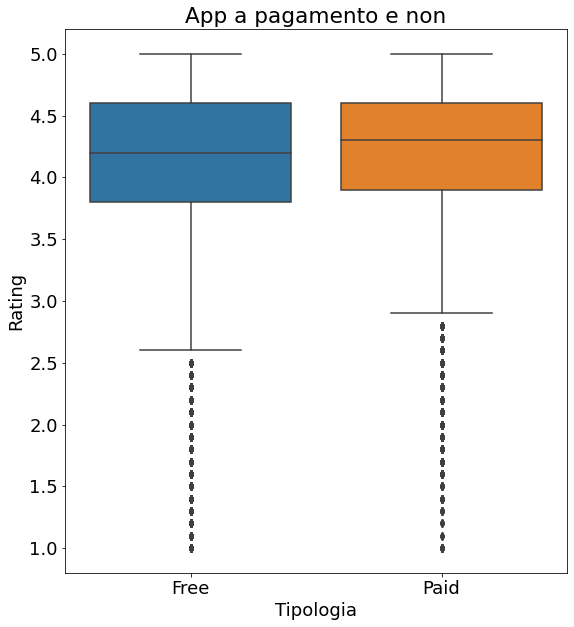

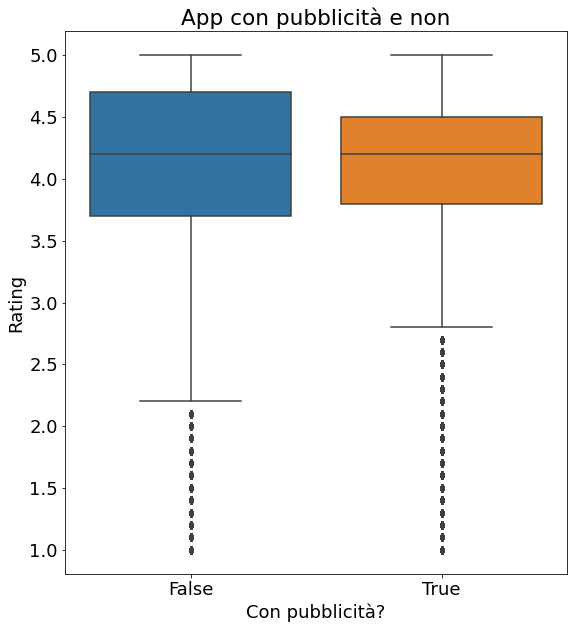

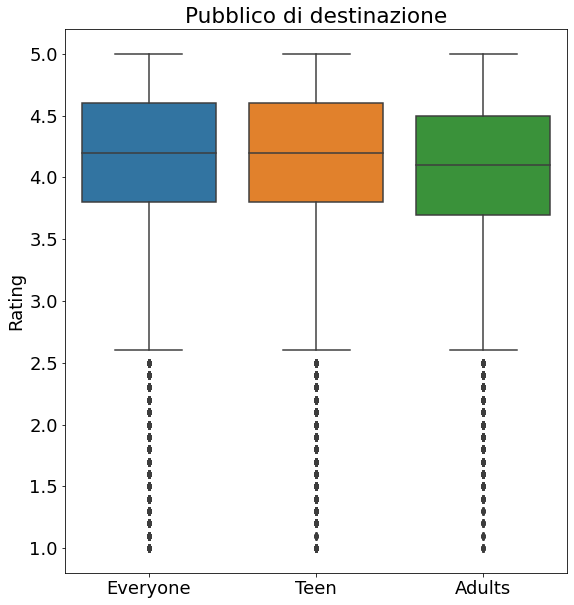

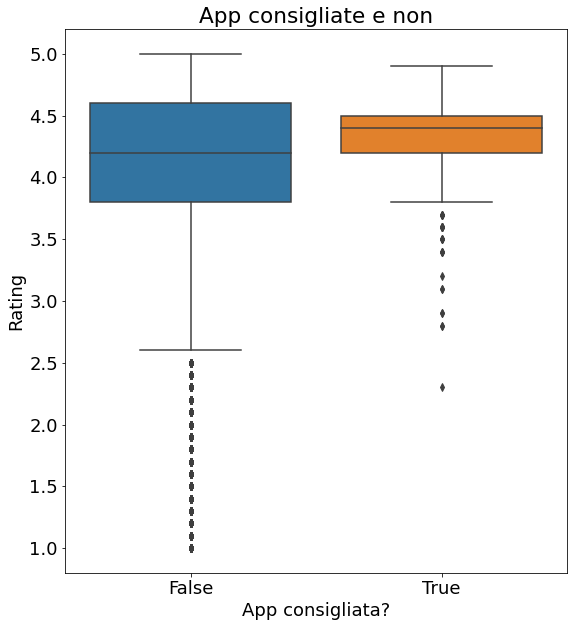

In [22]:
#RATING 2
#Confronto tra categorie
filtered_df = dataframe[dataframe['Rating'] != 0]

plt.figure(figsize=(15, 15))
sns.boxplot(y=filtered_df['Category'], x=filtered_df['Rating'], order=sorted(dataframe['Category'].unique()))
plt.xlabel('Categoria')
plt.ylabel('Rating')
plt.title('Rating Medio per Categoria')


#Confronto tra app a pagamento e non
filtered_df = dataframe[dataframe['Rating'] != 0]

plt.figure(figsize=(9, 10))
sns.boxplot(x=filtered_df['Type'], y=filtered_df['Rating'])
plt.xlabel('Tipologia')
plt.ylabel('Rating')
plt.title('App a pagamento e non')


#Confronto tra app con pubblicità e non
filtered_df = dataframe[dataframe['Rating'] != 0]

plt.figure(figsize=(9, 10))
sns.boxplot(x=filtered_df['Ad Supported'], y=filtered_df['Rating'])
plt.xlabel('Con pubblicità?')
plt.ylabel('Rating')
plt.title('App con pubblicità e non')


#Confronto tra destinazione ETA diversa
filtered_df = dataframe[dataframe['Rating'] != 0]

plt.figure(figsize=(9, 10))
sns.boxplot(x=filtered_df['Content Rating'], y=filtered_df['Rating'])
plt.xlabel('')
plt.ylabel('Rating')
plt.title('Pubblico di destinazione')



#Confronto tra app consigliate e non
filtered_df = dataframe[dataframe['Rating'] != 0]

plt.figure(figsize=(9, 10))
sns.boxplot(x=filtered_df['Editors Choice'], y=filtered_df['Rating'])
plt.xlabel('App consigliata?')
plt.ylabel('Rating')
plt.title('App consigliate e non')




plt.show()

<AxesSubplot:title={'center':'Fascia età e numero installazioni '}, xlabel='Installs', ylabel='Rating Count'>

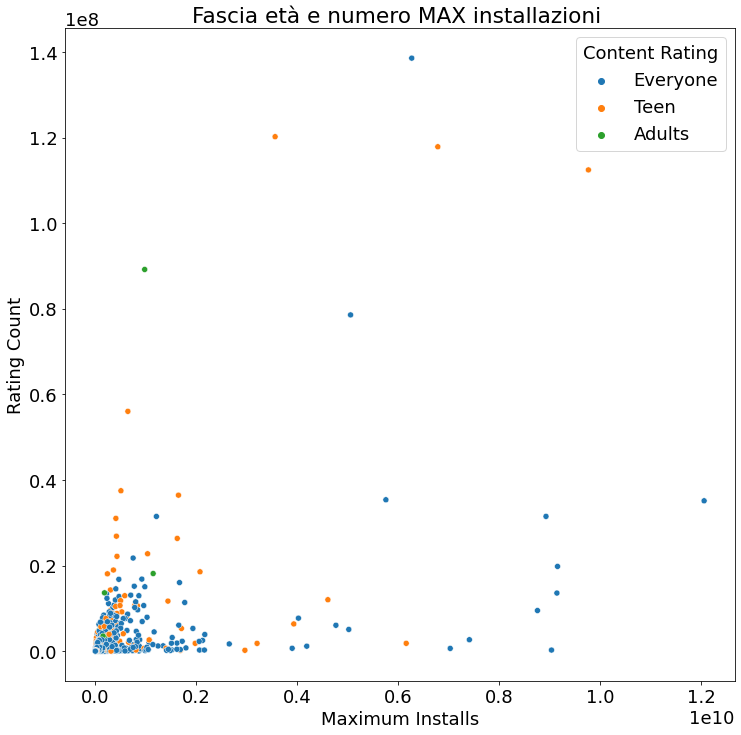

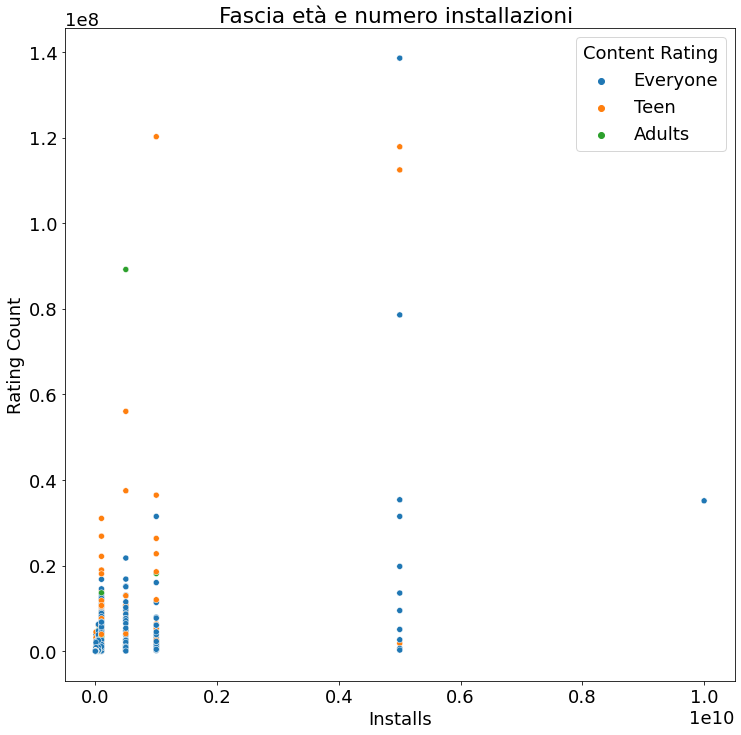

In [23]:
#RATING 3

plt.figure(figsize=(12,12))
plt.title("Fascia età e numero MAX installazioni ")
sns.scatterplot(x='Maximum Installs',y='Rating Count',data=dataframe,hue='Content Rating')


plt.figure(figsize=(12,12))
plt.title("Fascia età e numero installazioni ")
sns.scatterplot(x='Installs',y='Rating Count',data=dataframe,hue='Content Rating')

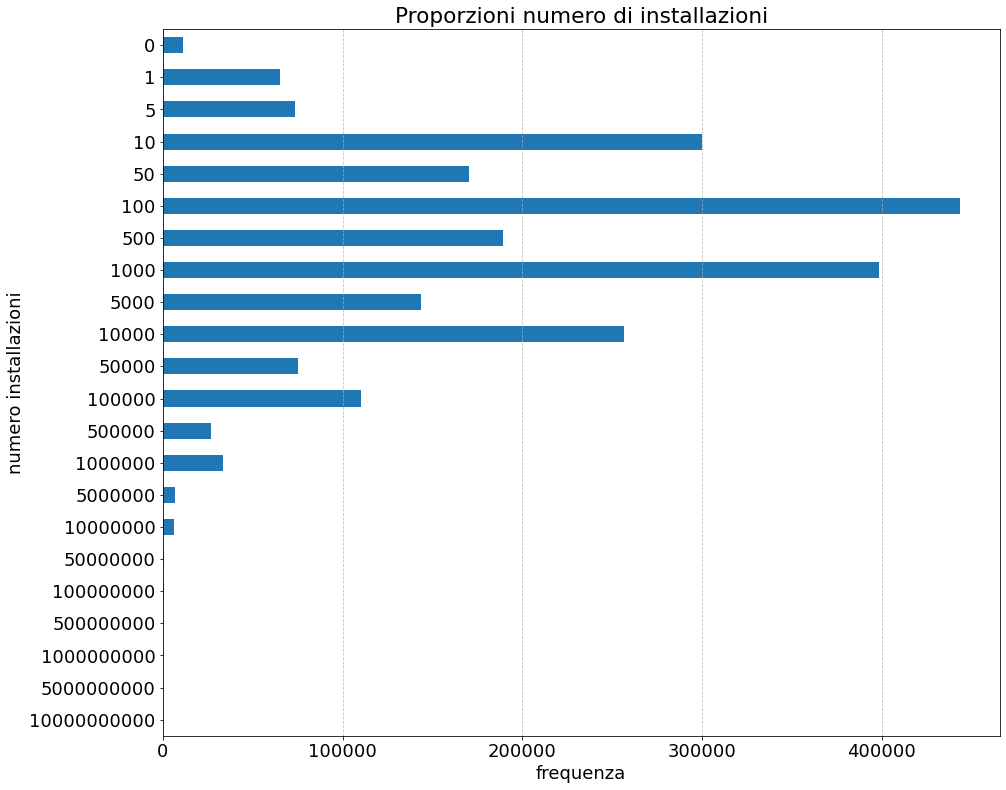

0               11564
1               65325
5               73750
10             300101
50             170437
100            443332
500            189058
1000           398184
5000           143587
10000          256711
50000           75357
100000         110251
500000          27011
1000000         33650
5000000          6595
10000000         6191
50000000          824
100000000         549
500000000          65
1000000000         55
5000000000         14
10000000000         1
Name: Installs, dtype: int64

In [24]:
#NUMERO INSTALLAZIONI
fig, ax = plt.subplots(figsize=(15,13))

dataframe['Installs'].value_counts().sort_index(ascending=False).plot.barh()

ax.set(title='Proporzioni numero di installazioni',
       xlabel='frequenza', ylabel='numero installazioni')

plt.grid(axis='x', linestyle='--', alpha=0.8)    

plt.show();

dataframe['Installs'].value_counts().sort_index()


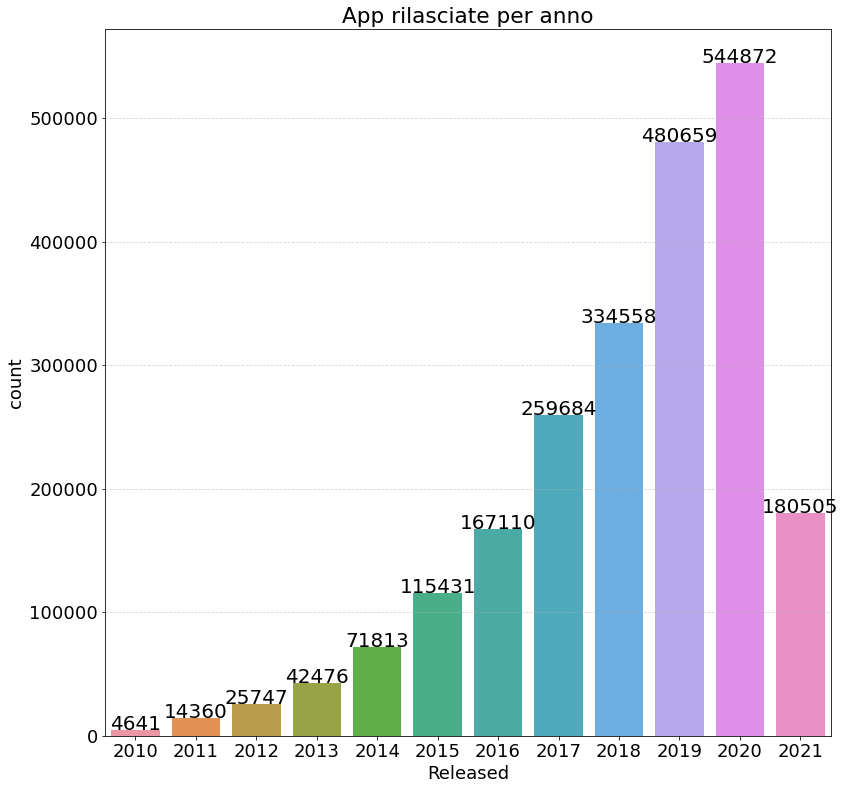

In [25]:
#APP RILASCIATE PER ANNO
plt.figure(figsize=(13,13))
ax = sns.countplot(dataframe[dataframe['Released'] > 0]['Released']);
plt.title("App rilasciate per anno")

for p in ax.patches:
    ax.annotate(p.get_height(),(p.get_x() + p.get_width()/2,p.get_height()),ha='center',size= 20)
plt.grid(axis='y', linestyle='--', alpha=0.5)    
plt.show()

In [50]:
top10Installs=dataframe.sort_values(by=['Maximum Installs'], ascending=False)
top10Installs.head(60)

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
2155096,Google Play services,com.google.android.gms,Tools,4.2,35128398.0,"10,000,000,000+",1.000000e+10,12057627016,True,0.0,...,https://developers.google.com/android/google-p...,apps-help@google.com,"May 24, 2012","Jun 10, 2021",Everyone,http://www.google.com/policies/privacy,False,False,False,2021-06-16 10:41:26
881403,YouTube,com.google.android.youtube,Video Players & Editors,4.4,112440547.0,"5,000,000,000+",5.000000e+09,9766230924,True,0.0,...,https://support.google.com/youtube/topic/24225...,ytandroid-support@google.com,"Oct 20, 2010","Jun 16, 2021",Teen,http://www.google.com/policies/privacy,True,False,False,2021-06-16 10:28:37
1773294,Google,com.google.android.googlequicksearchbox,Tools,4.2,19798962.0,"5,000,000,000+",5.000000e+09,9154248491,True,0.0,...,https://www.google.com/search/about/,apps-help@google.com,"Aug 12, 2010","Jun 11, 2021",Everyone,http://www.google.com/policies/privacy,True,False,False,2021-06-16 05:12:00
1733042,Google Maps - Navigate & Explore,com.google.android.apps.maps,Travel & Local,3.8,13576045.0,"5,000,000,000+",5.000000e+09,9141671889,True,0.0,...,http://maps.google.com/about/,apps-help@google.com,NaN,"Jun 15, 2021",Everyone,http://www.google.com/policies/privacy,True,False,True,2021-06-16 04:38:02
1060335,Google Text-to-Speech,com.google.android.tts,Tools,4.1,254700.0,"5,000,000,000+",5.000000e+09,9034404884,True,0.0,...,http://www.google.com/,tts-feedback@google.com,"Oct 10, 2013","Mar 29, 2021",Everyone,http://www.google.com/policies/privacy,False,False,False,2021-06-16 13:16:56
944254,Google Chrome: Fast & Secure,com.android.chrome,Communication,4.1,31481796.0,"5,000,000,000+",5.000000e+09,8925640788,True,0.0,...,http://www.google.com/chrome/android,apps-help@google.com,"Feb 7, 2012","Jun 14, 2021",Everyone,http://www.google.com/chrome/intl/en/privacy.html,False,False,False,2021-06-16 11:26:31
2099458,Gmail,com.google.android.gm,Communication,4.2,9488421.0,"5,000,000,000+",5.000000e+09,8756574289,True,0.0,...,http://support.google.com/mail/bin/topic.py?hl...,apps-help@google.com,"Sep 21, 2010","Jun 16, 2021",Everyone,http://www.google.com/policies/privacy,True,False,False,2021-06-16 09:53:00
2011395,Android Accessibility Suite,com.google.android.marvin.talkback,Tools,4.2,2666450.0,"5,000,000,000+",5.000000e+09,7408134567,True,0.0,...,https://developer.android.com/guide/topics/ui/...,apps-help@google.com,NaN,"May 19, 2021",Everyone,http://www.google.com/policies/privacy,False,False,False,2021-06-16 08:36:32
893676,Google Drive,com.google.android.apps.docs,Productivity,4.3,639307.0,"5,000,000,000+",5.000000e+09,7028265259,True,0.0,...,https://support.google.com/drive/?p=android_dr...,apps-help@google.com,"Apr 27, 2011","Jun 09, 2021",Everyone,http://www.google.com/policies/privacy,False,True,False,2021-06-16 10:39:49
2222701,Facebook,com.facebook.katana,Social,2.3,117850066.0,"5,000,000,000+",5.000000e+09,6782619635,True,0.0,...,https://www.facebook.com/facebook,facebook.android@fb.com,NaN,"Jun 16, 2021",Teen,https://www.facebook.com/about/privacy/,True,True,False,2021-06-16 11:40:20


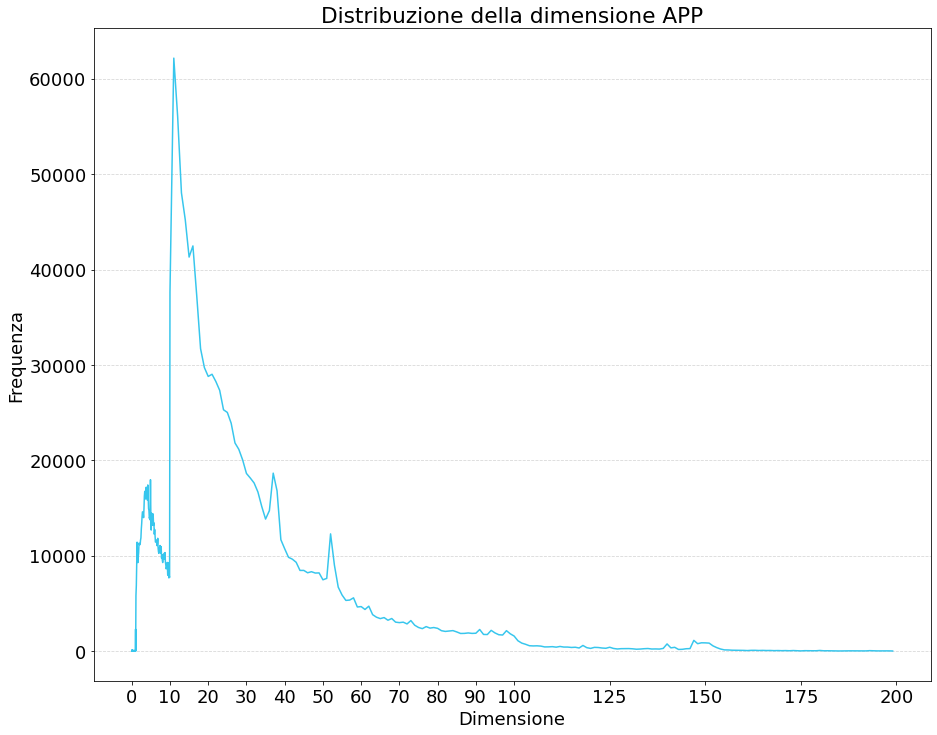

In [102]:
#DISTRIBUZIONE GRANDEZZA APP SENZA I VALORI 
over_0 = dataframe[(dataframe['Size'] > 0) & (dataframe['Size'] < 200)]['Size']

plt.figure(figsize=(15, 12))

rec_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200]
value_counts = over_0.value_counts().sort_index()

plt.plot(value_counts.index, value_counts.values, linestyle='-', color='#37c6ed')

plt.xlabel('Dimensione')
plt.ylabel('Frequenza')
plt.title('Distribuzione della dimensione APP')
plt.xticks(rec_bins)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()





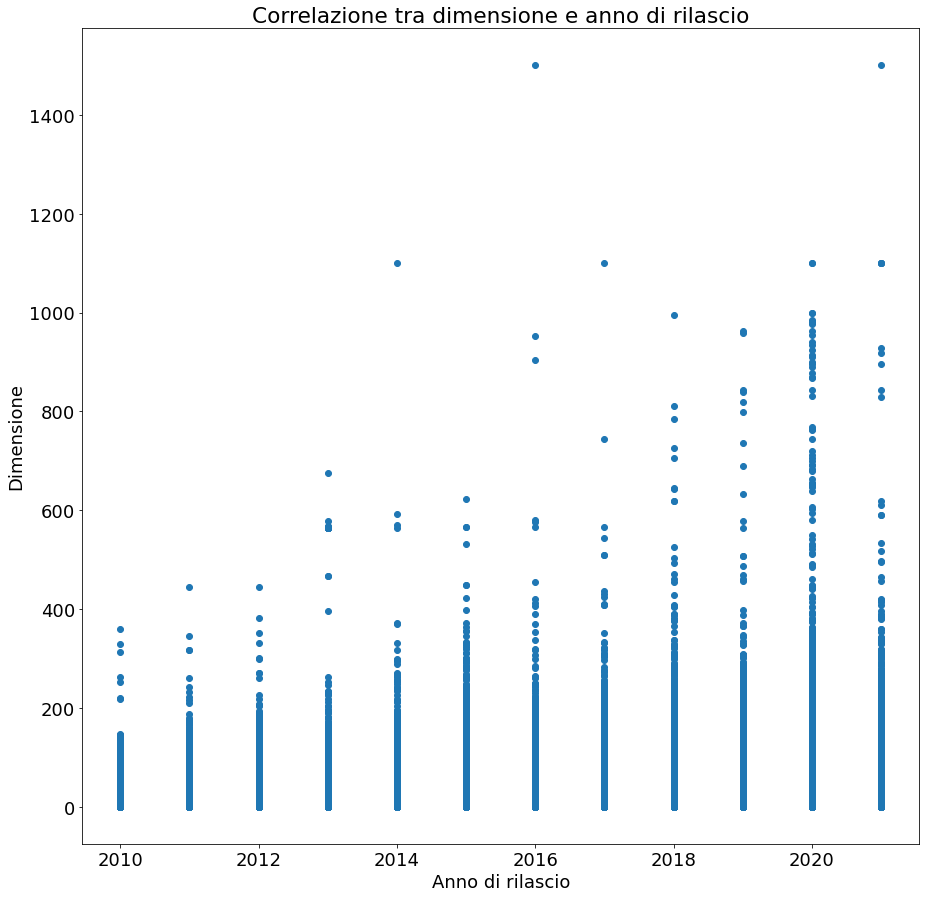

In [112]:
released = dataframe[(dataframe['Released'] > 0)&(dataframe['Size'] > 0)]['Released']
size = dataframe[(dataframe['Released'] > 0)&(dataframe['Size'] > 0)]['Size']

plt.figure(figsize=(15, 15))
plt.scatter(released, size)
plt.xlabel('Anno di rilascio')
plt.ylabel('Dimensione')
plt.title('Correlazione tra dimensione e anno di rilascio')

plt.show()

In [111]:
dataframe['Released'].corr(dataframe['Size'])

0.034910881135798315